In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import spaceweather as sw  
import pandas as pd 
import streamlit as st
import numpy as np
from core import forecast
import plotly.express as px
import plotly.graph_objs as go

In [2]:
sw_data = sw.celestrak.sw_daily(update=True)
sw_data.index = pd.to_datetime(sw_data.index)
current_datetime = datetime.utcnow()
current_data = sw_data.loc[:current_datetime].iloc[-1]
prev_data = sw_data.loc[:current_datetime].iloc[-2]

agos = [current_datetime - timedelta(weeks=1),
        current_datetime - timedelta(days=30),
        current_datetime - timedelta(days=365),
        current_datetime - timedelta(days=90)]

# kp_index = current_data["Kp0"].astype(float)
Apavg = current_data["Apavg"].astype(float)
f107_observed = current_data["f107_obs"].astype(float)

# Daily geomagnetic activity index (0–2.5)
Cp = current_data['Cp'].astype(float)

# International sunspot number
isn = current_data['isn'].astype(float)

bsrn = current_data['bsrn'].astype(float)
rotd = current_data['rotd'].astype(float)

properties = {"Ap":"Apavg",
                  "Solar Flux (Adjusted to 1 AU)":"f107_adj", 
                  "Cp":"Cp", 
                  "Sunspot Number":"isn",
                  "Bartels Solar Rotation Number":"bsrn",
                  "Bartels Rotation Day":"rotd"}

current_datetime = current_data.name

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\944314474.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_datetime = datetime.utcnow()


In [4]:
ago = agos[2]
data_range = sw_data.loc[ago:current_datetime]

In [19]:
def moving_average_np(data, window_size):
    """
    Calculates the simple moving average of a 1D array using numpy.convolve.

    Args:
        data (np.array): The input array.
        window_size (int): The size of the moving average window.

    Returns:
        np.array: The array containing the moving average.
    """
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def get_trend(y):
    # Get last X days worth, find general trend.
    # Note that 1 row of data = 1 day. 
    x = np.arange(1, len(y)+1)
    y_ave = moving_average_np(y, 30)
    x_ave = x[15:-14]
    
    # Fit the general trendline.
    
    # # Fit a linear trend (degree = 1)
    # coefficients_linear = np.polyfit(x, y_ave, 1)
    # linear_trend = np.poly1d(coefficients_linear)
    
    # Fit a quadratic trend (degree = 2)
    coefficients_quadratic = np.polyfit(x_ave, y_ave, 2)
    quadratic_trend = np.poly1d(coefficients_quadratic)
    return quadratic_trend

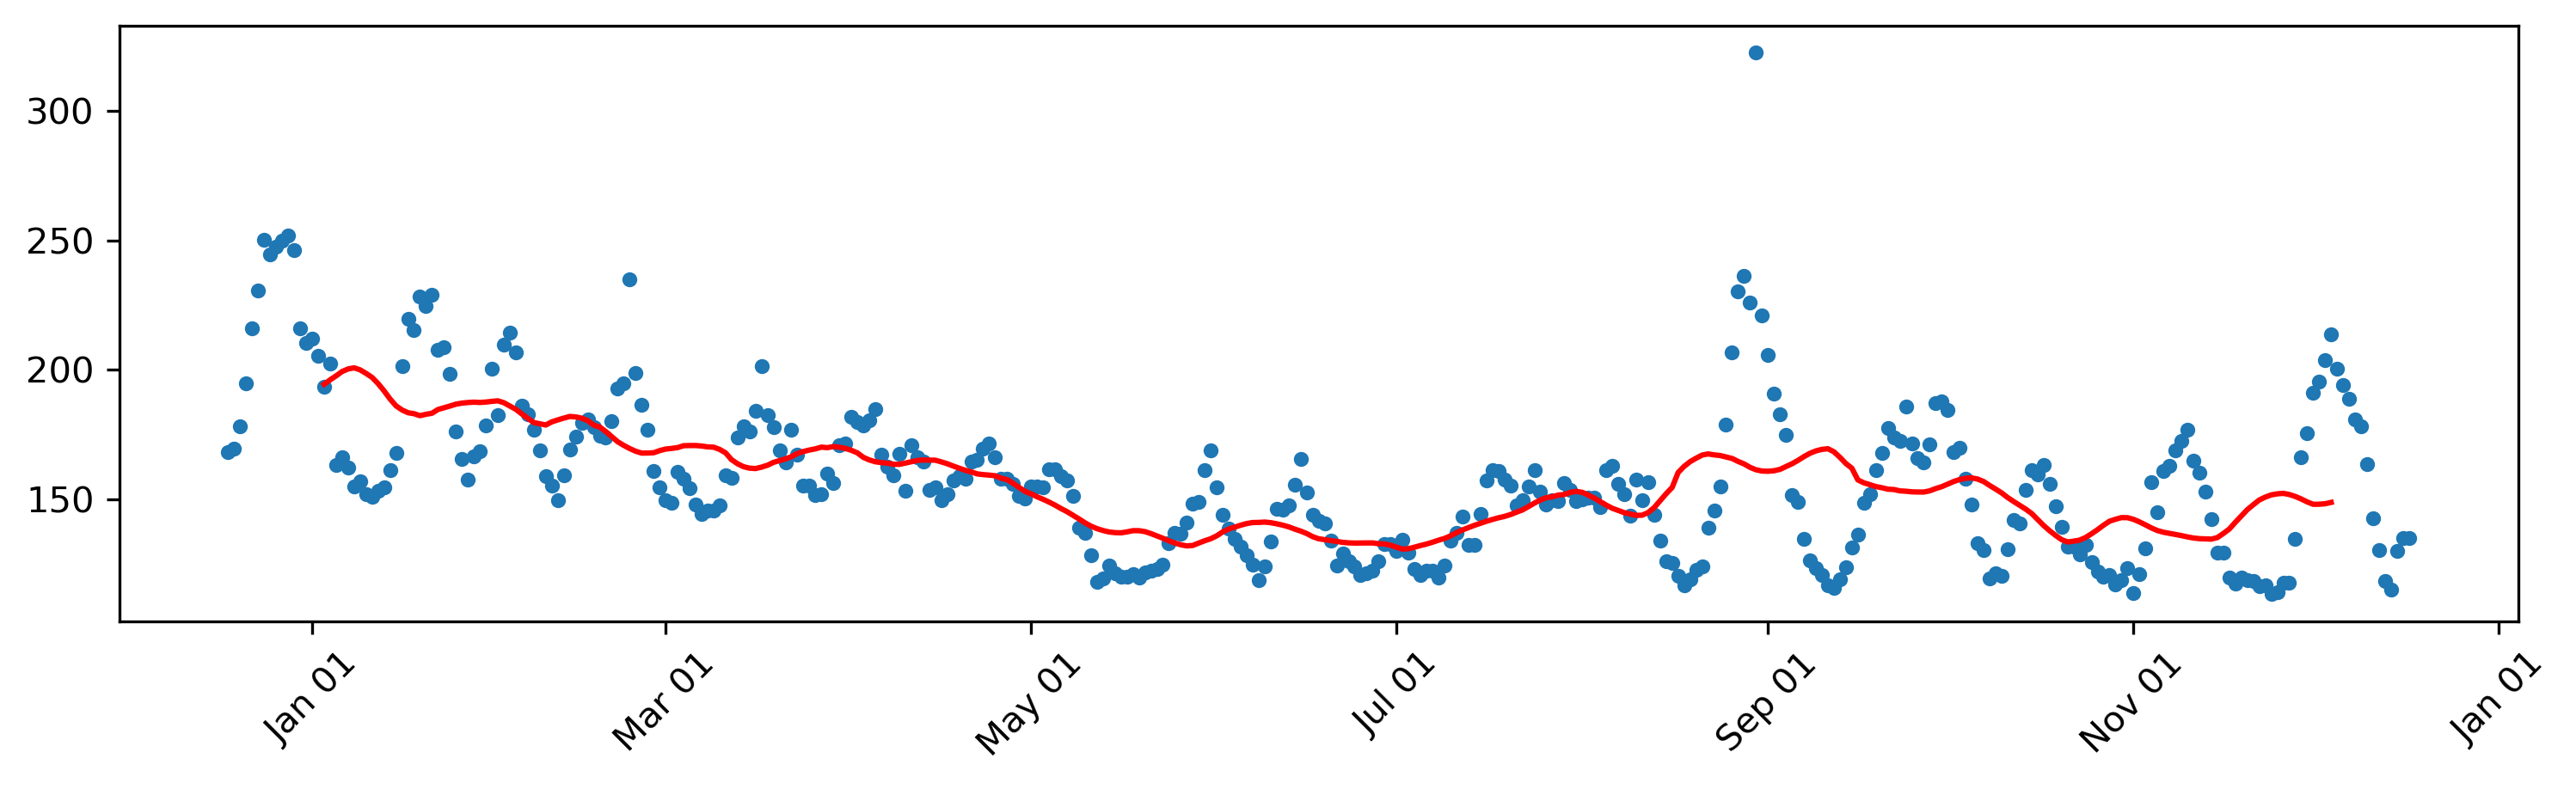

In [31]:
var_name = "f107_adj"
title = "Solar Flux (Adjusted to 1 AU)"

# Extract datetime and y-values.
times = data_range.index
values = data_range[var_name].values.astype(float) 
x = np.arange(1, len(times)+1)
y_ave = moving_average_np(values, 30)
x_ave = x[15:-14]

# --- Plot ---
# Create base scatter

plt.figure(figsize=(12,3), dpi=300)
plt.scatter(
    x=times,
    y=values,
    s=10
    #mode="markers",
    # marker=dict(
    #     size=10,
    #     color=values,
    #     colorscale="RdYlGn_r",   # low=green, high=red
    #     showscale=True,
    #     colorbar=dict(title=title),
    #     line=dict(color="black", width=0.7)
    # ),
)

plt.plot(times[x_ave], y_ave, color='black', label='Moving Average')

# x = np.arange(1, len(times)+1)
# plt.plot(times, get_trend(x), color='red')

# Format date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)

plt.show()

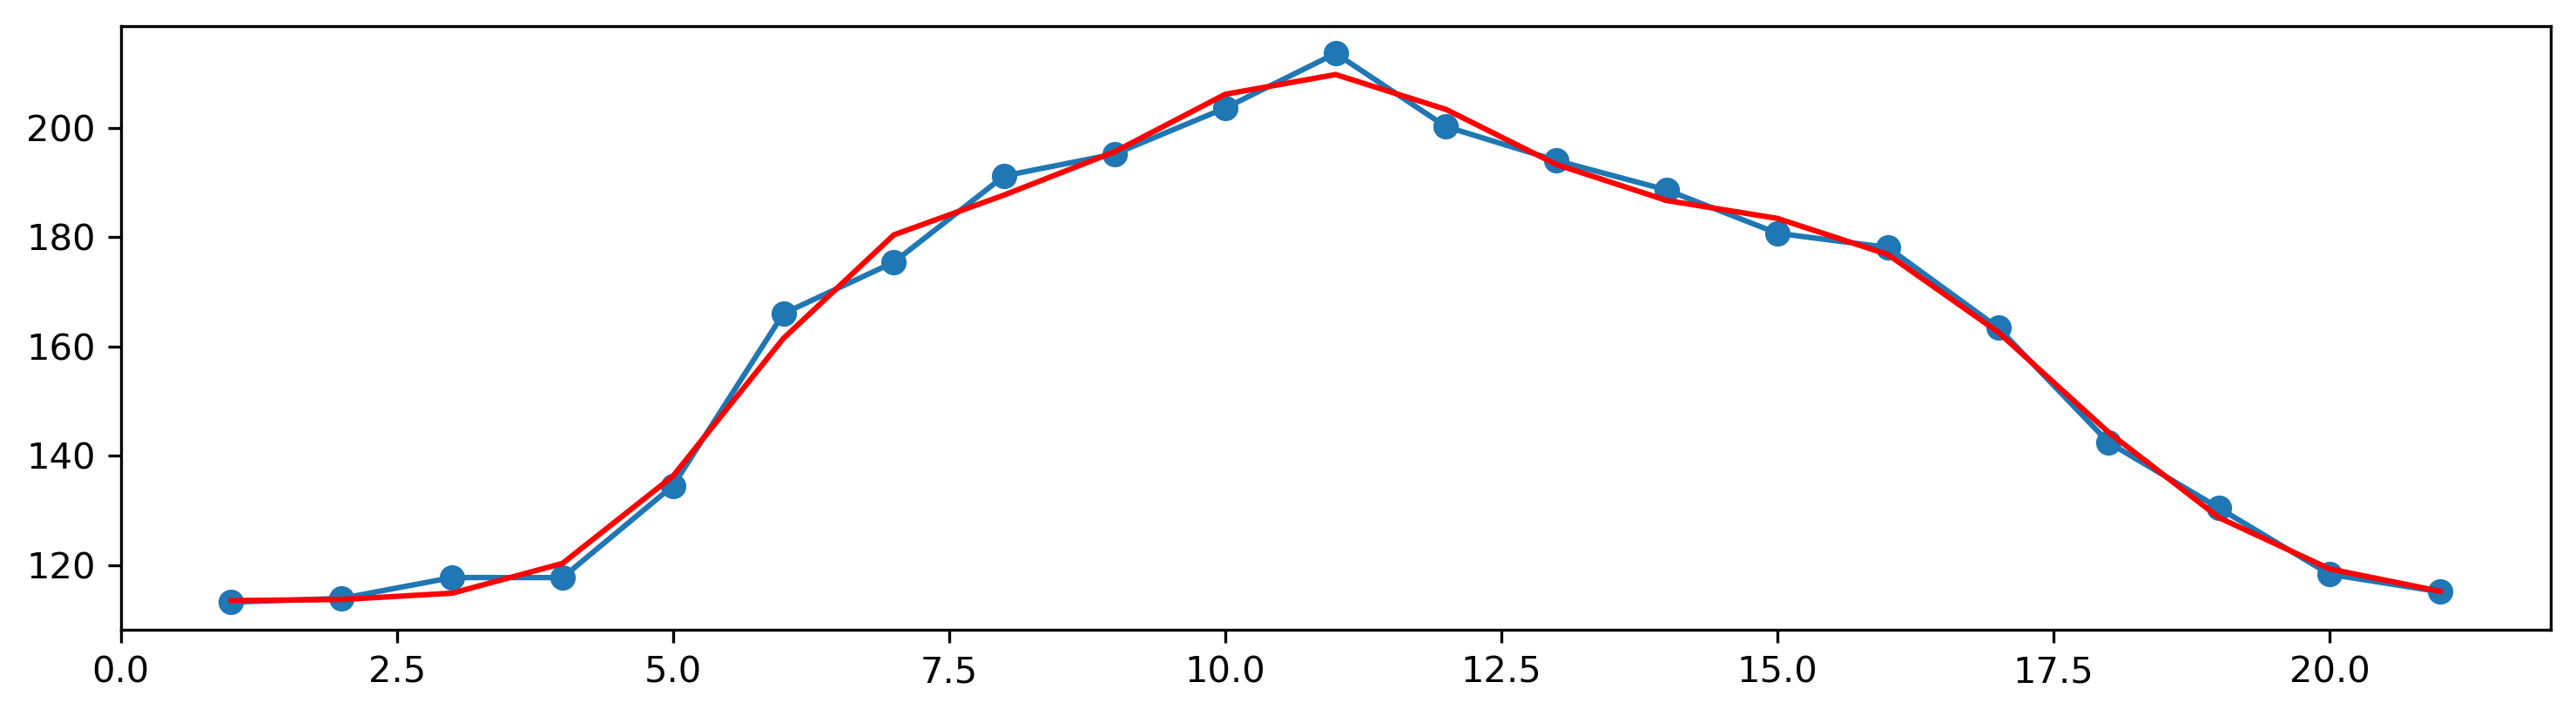

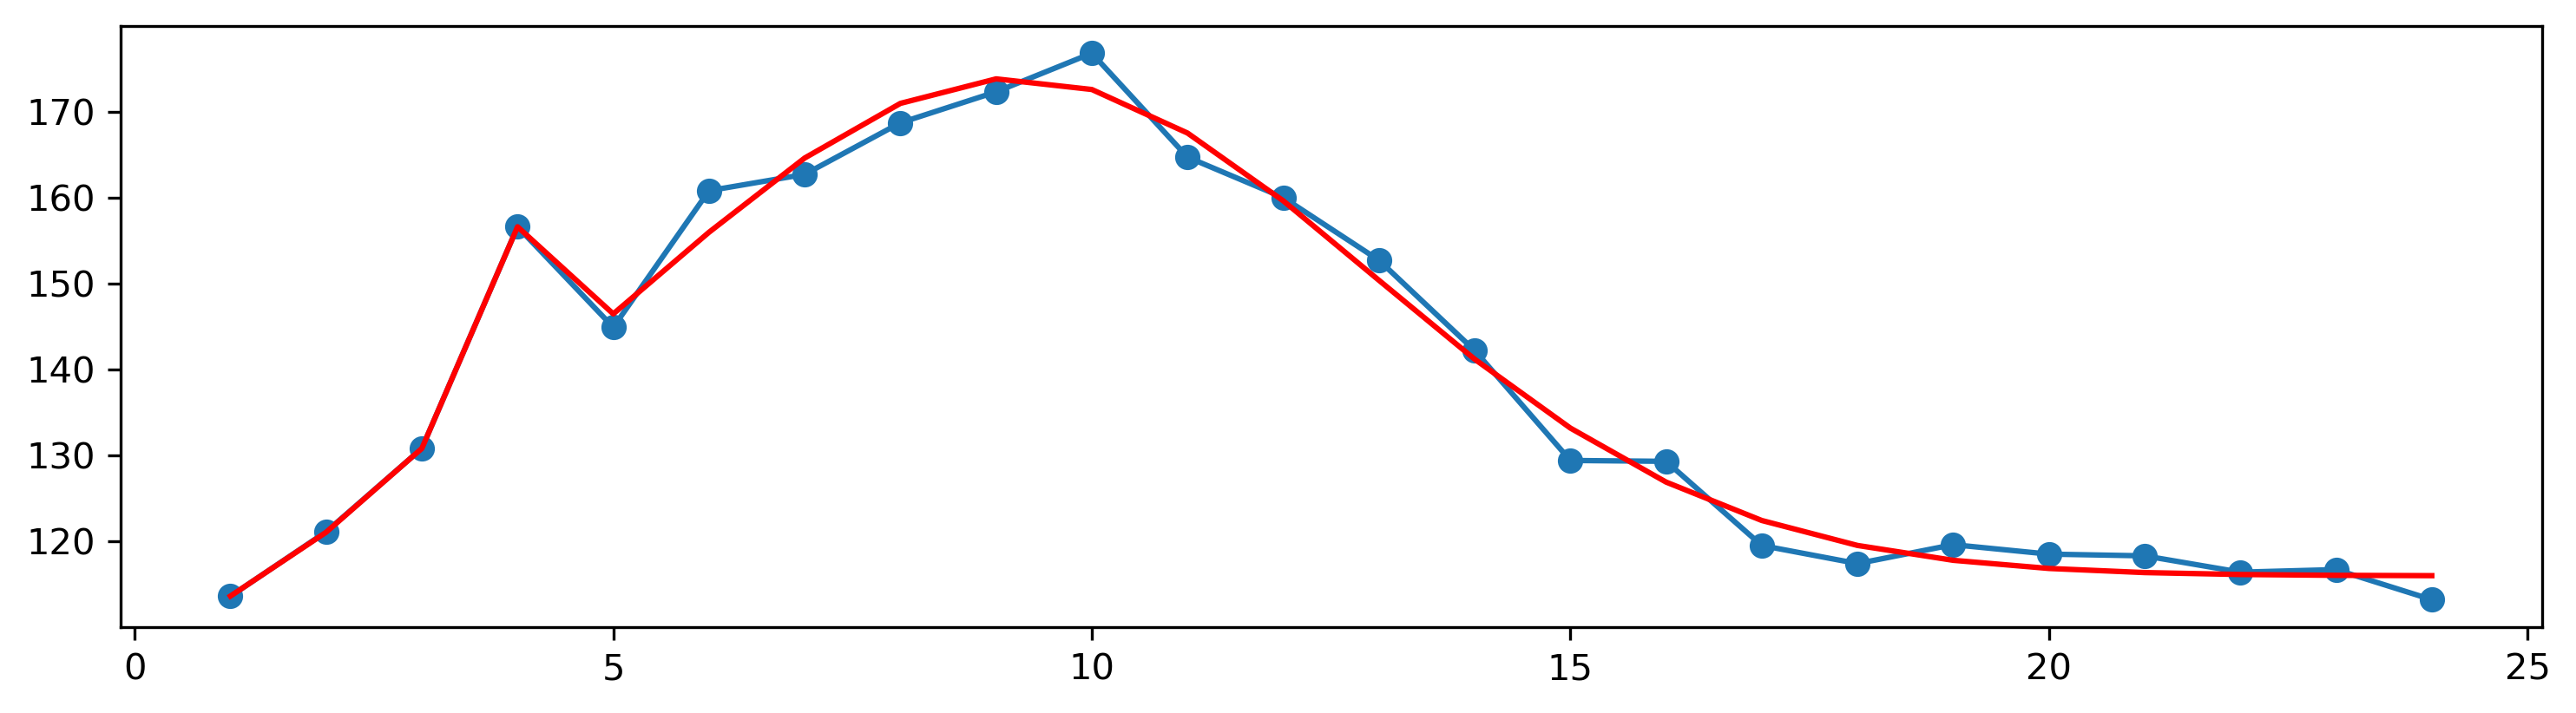

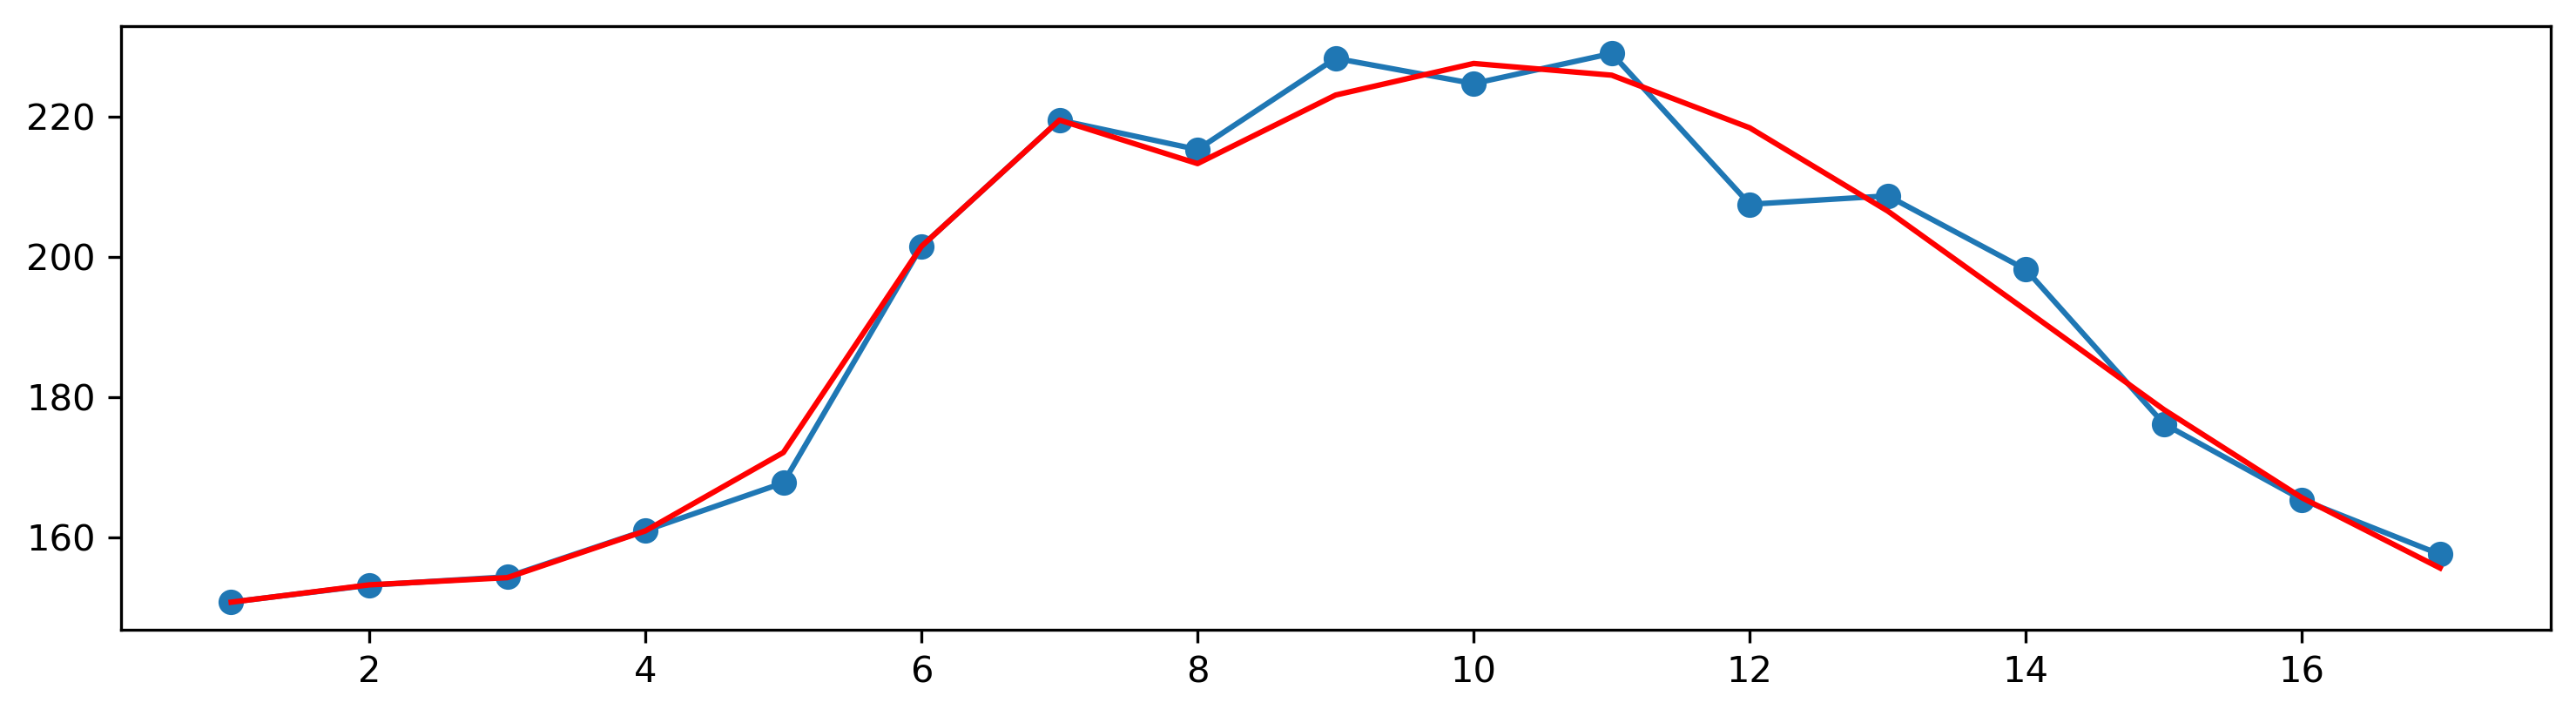

In [204]:
var_name = "f107_adj"
title = "Solar Flux (Adjusted to 1 AU)"

events = [
         (pd.Timestamp(year=2025, month=11, day=24), pd.Timestamp(year=2025, month=12, day=14)), 
         (pd.Timestamp(year=2025, month=11, day=1), pd.Timestamp(year=2025, month=11, day=24)), 
         (pd.Timestamp(year=2025, month=1, day=11), pd.Timestamp(year=2025, month=1, day=27)), 
         
         ]

for event in events:
    (x1, x2) = event
    data_range = sw_data.loc[x1:x2]
    
    # Extract datetime and y-values.
    times = data_range.index
    values = data_range[var_name].values.astype(float) 
    x = np.arange(1, len(times)+1)
    
    plt.figure(figsize=(12,3), dpi=300)
    plt.plot(
        x, values, #/np.nanmax(values),
        # s=10
        marker='o'
    )

    y0 = values[0]
    x2 = np.argmax(values)
    x1 = int(x2/2)
    x3 = int(x2*1.5)
    A1 = np.nanmax(values)*2/3
    A2 = np.nanmax(values)
    A3 = np.nanmax(values)*2/3
    sigma1 = 1.5
    sigma2 = 3
    sigma3 = 3
    
    def fitting_fcn(x, x1, x2, x3, A1, A2, A3, sigma1, sigma2, sigma3, y0):
        y1 = A1 * np.exp(-((x - x1)**2) / (2 * sigma1**2))
        y2 = A2 * np.exp(-((x - x2)**2) / (2 * sigma2**2))
        y3 = A3 * np.exp(-((x - x3)**2) / (2 * sigma3**2))
        return y0 + y1 + y2 + y3
    
    p0 = (x1, x2, x3, A1, A2, A3, sigma1, sigma2, sigma3, y0)
    params, __ = curve_fit(fitting_fcn, x, values, p0=p0)
    plt.plot(x, fitting_fcn(x, *params), color='red')
    plt.show()

In [202]:
def asymmetric_gaussian(x, mu, sigma_1, sigma_2, A):
    """
    Asymmetric Gaussian function.
    """
    return np.where(
        x <= mu,
        A * np.exp(-((x - mu)**2) / (2 * sigma_1**2)),  # Left side
        A * np.exp(-((x - mu)**2) / (2 * sigma_2**2))   # Right side
    )

In [143]:
# def fitting_fcn(x, x1, x2, x3, A, sigma_1, sigma_2, y0):
#     y1 = A/2 - (x-x1)**2
#     y2 = np.where(
#         x <= x2,
#         A * np.exp(-((x - x2)**2) / (2 * sigma_1**2)),  # Left side
#         A * np.exp(-((x - x2)**2) / (2 * sigma_2**2))   # Right side
#     )
#     y3 = A/2 - (x-x3)**2
#     curve = y0 + y1 + y2 + y3
#     return curve


In [125]:
from scipy.optimize import curve_fit

In [ ]:
# curve_fit(
#     f,
#     xdata,
#     ydata,
#     p0=None,
#     sigma=None,
#     absolute_sigma=False,
#     check_finite=None,
#     bounds=(-inf, inf),
#     method=None,
#     jac=None,
#     *,
#     full_output=False,
#     nan_policy=None,
#     **kwargs,
# )

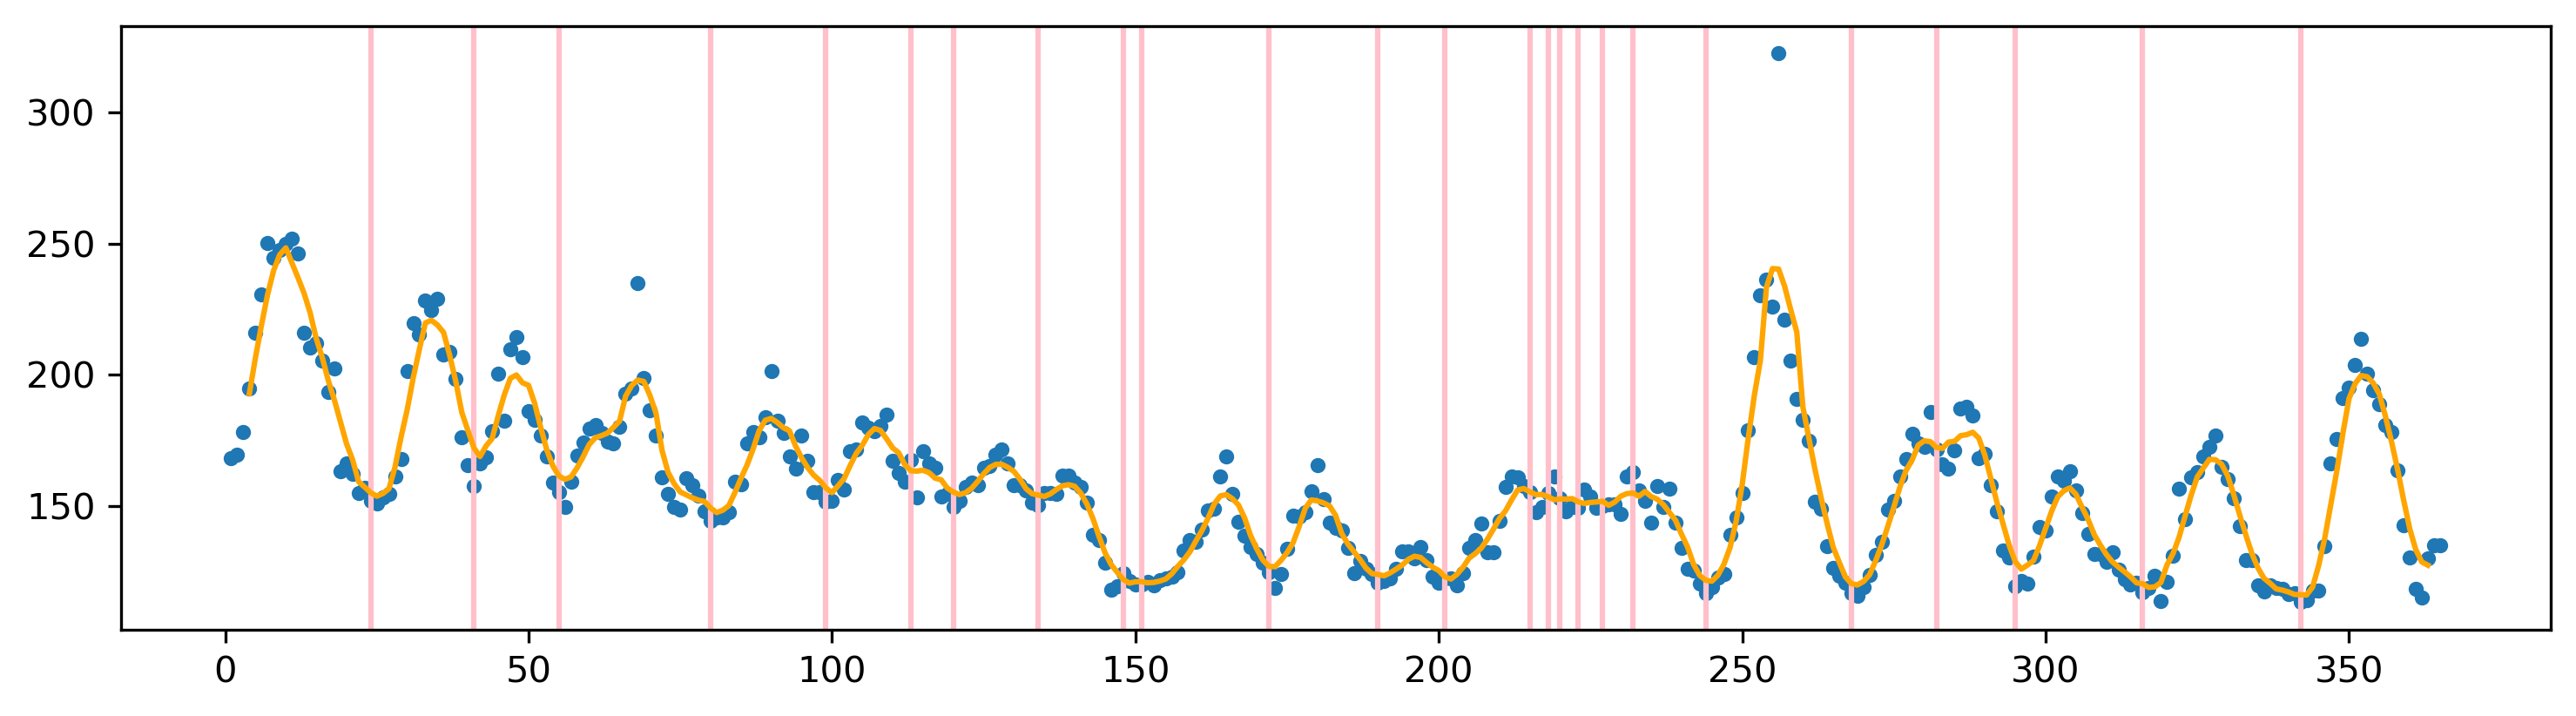

In [252]:
def find_downtimes(y_arr):
    window_size = 2
    for i in range(window, len(y_arr)-window_size):
        window = y_arr[i-window_size:i+window_size]
        ave = np.nanmean(window)
        

data_range = sw_data.loc[agos[2]:current_datetime]
times = data_range.index
values = data_range[var_name].values.astype(float) 
x = np.arange(1, len(times)+1)
y_ave = moving_average_np(values, 6)
x_ave = x[3:-2]

plt.figure(figsize=(12,3), dpi=300)


def get_first_1_indices(arr):
    indices = []
    for i, value in enumerate(arr):
        # A series of 1s starts if the current value is 1
        # AND it's either the first element (i == 0)
        # or the previous element was not 1 (arr[i-1] != 1)
        if value == 1 and (i == 0 or arr[i-1] != 1):
            indices.append(i)
    return indices

def get_last_neg1_indices(arr):
    indices = []
    for i, value in enumerate(arr):
        # A series of -1s ends if the current value is -1
        # AND it's either the last element (i == len(arr))
        # or the next element is not -1 (arr[i+1] != -1)
        if i < len(arr)-1:
            if value == -1 and (i == len(arr) or arr[i+1] != -1):
                indices.append(i)
    return indices

signs = np.sign(np.diff(y_ave))
vlines = get_last_neg1_indices(signs)
for vline in vlines:
    plt.axvline(x=vline+3+1, color='pink')

# changes = np.diff(signs)
# falling = True
# for s, sign in enumerate(signs):
#     if sign==1 and falling:
#         plt.axvline(x=x_ave[s], color='pink')
#         falling = False

plt.scatter(x, values, s=10)
plt.plot(x_ave, y_ave, color='orange', label='Moving Average')
plt.show()

## Apply fitting function to full year history

In [254]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

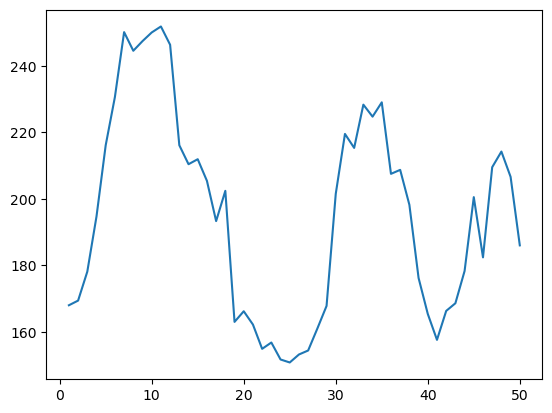

In [264]:
plt.plot(X_train, y_train)

In [328]:
def get_fit(x, values):
    y0 = values[0]
    x2 = np.argmax(values)
    x1 = int(x2/2)
    x3 = int(x2*1.5)
    A1 = np.nanmax(values)*2/3
    A2 = np.nanmax(values)
    A3 = np.nanmax(values)*2/3
    sigma1 = 1.5
    sigma2 = 3
    sigma3 = 3
    
    def fitting_fcn(x, x1, x2, x3, A1, A2, A3, sigma1, sigma2, sigma3, y0):
        y1 = A1 * np.exp(-((x - x1)**2) / (2 * sigma1**2))
        y2 = A2 * np.exp(-((x - x2)**2) / (2 * sigma2**2))
        y3 = A3 * np.exp(-((x - x3)**2) / (2 * sigma3**2))
        # return y0 + y1 + y2 + y3
        return y1 + y2 + y3
    
    p0 = (x1, x2, x3, A1, A2, A3, sigma1, sigma2, sigma3, y0)
    params, __ = curve_fit(fitting_fcn, x, values, p0=p0)
    #plt.plot(x, fitting_fcn(x, *params), color='red')
    return params, fitting_fcn

In [378]:
data_range[var_name]

1957-10-01    269.8
1957-10-02    253.6
1957-10-03    266.4
1957-10-04    238.2
1957-10-05    246.0
              ...  
2025-12-13    118.3
2025-12-14    115.1
2025-12-15    130.0
2025-12-16    135.0
2025-12-17    135.0
Name: f107_adj, Length: 24915, dtype: float64

In [377]:
var_name

'f107_adj'

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\214054508.py:21: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\haley\AppData\Local\Temp\

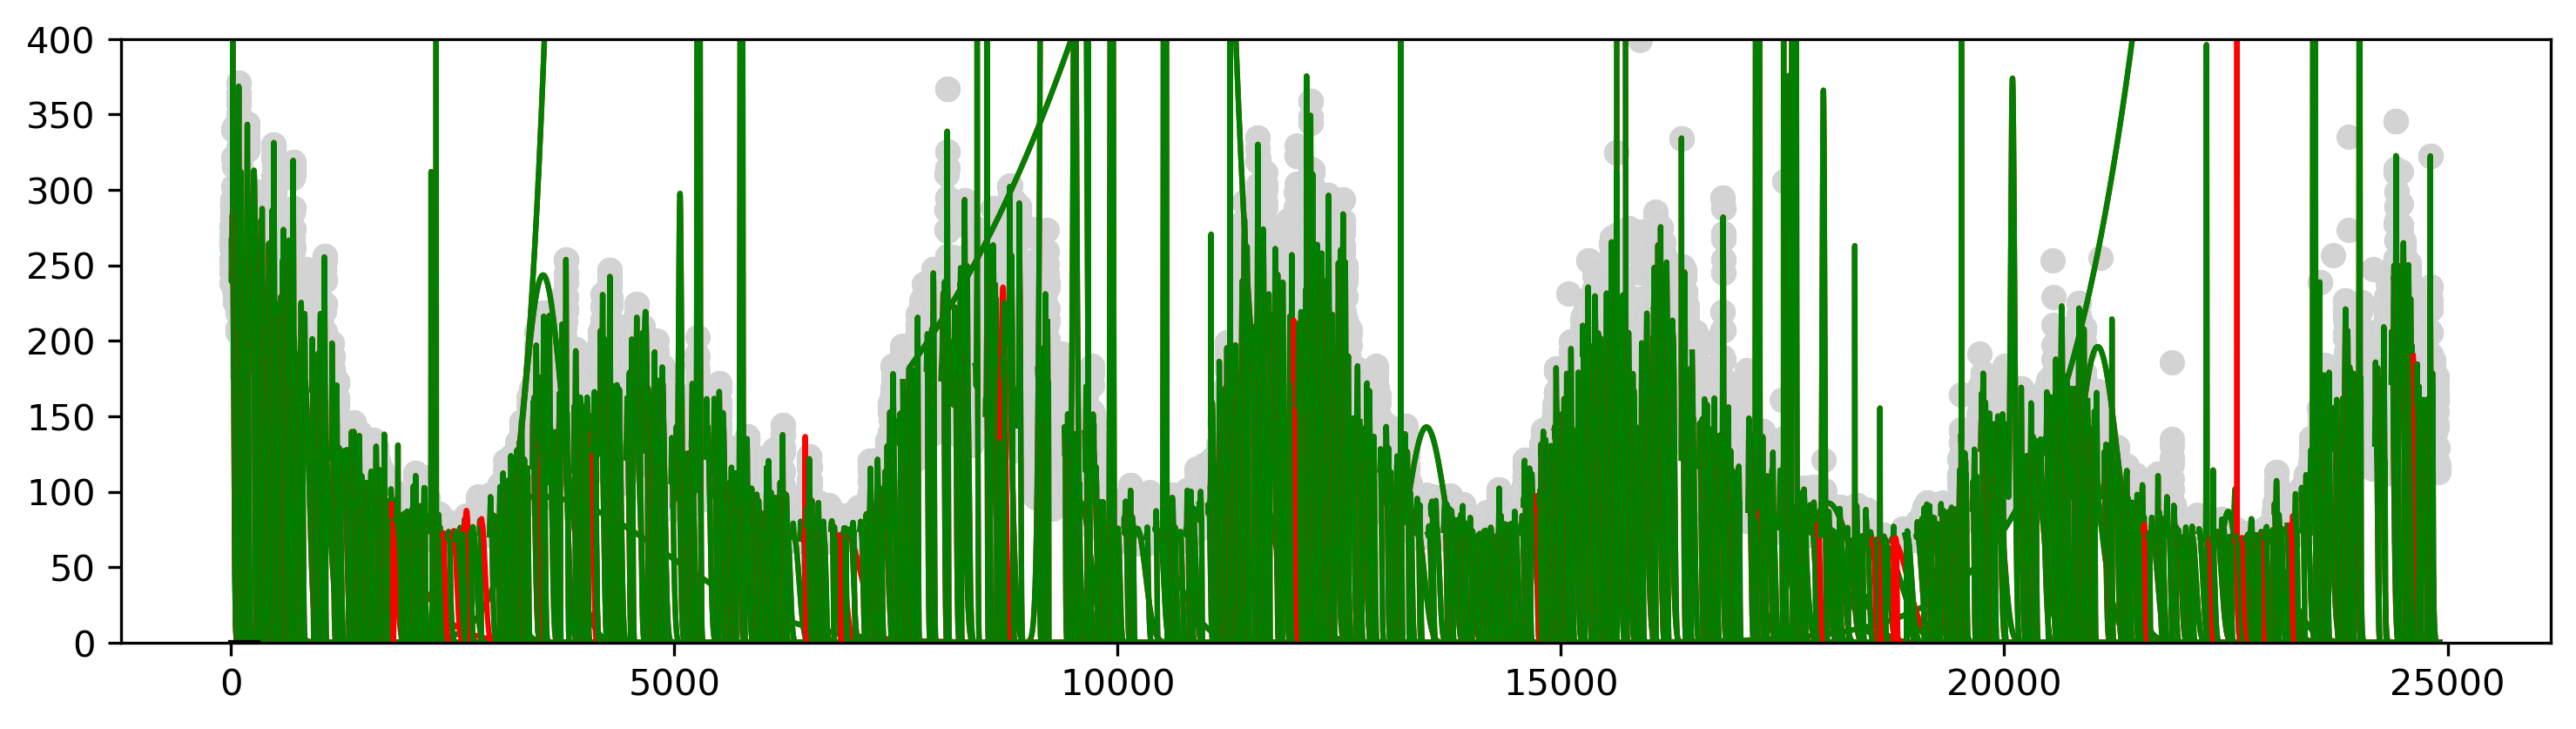

In [381]:
data_range = sw_data.loc[:current_datetime] #loc[agos[2]:current_datetime]
times = data_range.index
values = data_range[var_name].values.astype(float) 
x = np.arange(1, len(times)+1)
# y_ave = moving_average_np(values, 6)
# x_ave = x[3:-2]

ascending = True
onset = 0

plt.figure(figsize=(12,3), dpi=300)

events_db = {}
goodfit_events_db = {}
total_flux_arr = np.zeros(300)

for t in range(5, len(times)-5):
    # Check if new event starts at this timestep.
    window_size = 5
    y_range = values[t-window_size:t+1]
    y_val = values[t]
    diff = np.nanmean(np.diff(y_range))
    if diff > 0 and not ascending:
        ascending = True
        # print("New event at t =", t)
        
        this_event = values[onset:t+1]

        for past_event_onset in events_db:
            past_event_params = events_db[past_event_onset]
            past_fit = fitting_fcn(x[onset:t+1]-past_event_onset, *past_event_params)
            this_event = this_event - past_fit
        
        last_10t = this_event[-10:]
        low_idx_in_last_10t = np.argmin(last_10t)
        low_idx = t-10+low_idx_in_last_10t+1
        
        this_event = values[onset:low_idx]

        # Finalize the fit for the current/ongoing event before starting new one.
        try:
            x0 = x[onset]
            params, fitting_fcn = get_fit(x[onset:low_idx]-x0, this_event)
            plt.scatter(x[onset:low_idx], values[onset:low_idx], color='skyblue')
            #plt.plot(x[onset:low_idx], fitting_fcn(x[onset:low_idx]-x0, *params), color='red')
            fit = fitting_fcn(x[onset:]-x0, *params)
            plt.plot(x[onset:], fit, color='red')
            #print(f"Event between {onset} and {t} has params: {params}")

            events_db[onset] = params
            total_flux = fitting_fcn(x[onset:low_idx]-x0, *params)

            # If this is a GOOD fit, then also save to the good list to be referenced later.
            r2 = r2_score(values[onset:low_idx], total_flux)
            # print("R2 Score:", r2)
            
            if r2 > 0.7:
                plt.plot(x[onset:], fit, color='green')
                goodfit_events_db[onset] = params

            for past_event_onset in events_db:
                past_event_params = events_db[past_event_onset]
                past_fit = fitting_fcn(x[onset:t+1]-past_event_onset, *past_event_params)
                total_flux+=past_fit[-1]

            total_flux_arr[onset:t+1] = total_flux
                
        except:
            #print("Skipping")
            plt.scatter(x[onset:low_idx], values[onset:low_idx], color='lightgray')
        onset = low_idx
        
        
    elif diff < 0 and ascending:
        ascending = False

plt.plot(total_flux_arr, color='black')
plt.ylim([0,400])
plt.show()
plt.close()

In [382]:
data_range.head()

,year,month,day,bsrn,rotd,Kp0,Kp3,Kp6,Kp9,Kp12,...,Cp,C9,isn,f107_adj,Q,f107_81ctr_adj,f107_81lst_adj,f107_obs,f107_81ctr_obs,f107_81lst_obs
1957-10-01,1957,10,1,1700,19,4.3,4.0,3.0,2.0,3.7,...,1.1,5,334,269.8,0,266.8,235.5,269.3,266.6,230.9
1957-10-02,1957,10,2,1700,20,3.7,3.7,1.7,1.7,2.7,...,0.7,3,331,253.6,0,267.5,236.2,253.3,267.4,231.7
1957-10-03,1957,10,3,1700,21,2.7,2.0,1.3,3.3,3.7,...,1.0,5,343,266.4,0,268.1,237.1,266.3,268.1,232.7
1957-10-04,1957,10,4,1700,22,3.0,3.0,2.3,2.7,2.3,...,0.7,3,307,238.2,0,268.7,237.7,238.2,268.8,233.3
1957-10-05,1957,10,5,1700,23,3.0,3.0,1.7,2.3,2.0,...,0.6,3,310,246.0,0,269.1,238.1,246.2,269.3,233.9


In [380]:
goodfit_events_db

{np.int64(2): array([-4.05261160e+00,  1.02737987e+01,  1.37354315e+01,  1.08598438e+03,
         2.83317687e+02,  1.15522380e+03,  1.60729547e+00,  1.45862972e+01,
         2.40066849e-01,  2.66400000e+02]),
 np.int64(17): array([  0.99829884,  11.13770943,  15.37534167, 293.63746959,
        108.69842953, 123.58787903,  12.56186588,   1.6301023 ,
          2.34243537, 293.7       ]),
 np.int64(40): array([  1.3671721 ,  13.37271677,  18.54535442, 231.89304045,
        275.31591683,  76.75253815,   4.63483034,   5.02515759,
          1.3923944 , 229.9       ]),
 np.int64(59): array([ 4.01945554e-01,  1.50684217e+00,  5.03682333e-01, -1.21083773e+02,
        -5.89816588e+01,  2.86077588e+02,  2.77092978e-01,  6.68845868e-02,
         1.37552684e+01,  2.43600000e+02]),
 np.int64(72): array([  5.71947483,  12.38088515,  24.2165456 , 224.17739548,
        167.23703611, 160.95515506,  12.97163694,   4.41823246,
          4.26420768, 206.        ]),
 np.int64(96): array([  9.5349645 ,   9.3

In [393]:
f107_db.index

DatetimeIndex(['1957-10-01', '1957-10-02', '1957-10-03', '1957-10-04',
               '1957-10-05', '1957-10-06', '1957-10-07', '1957-10-08',
               '1957-10-09', '1957-10-10',
               ...
               '2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11',
               '2025-12-12', '2025-12-13', '2025-12-14', '2025-12-15',
               '2025-12-16', '2025-12-17'],
              dtype='datetime64[ns]', length=24915, freq=None)

In [394]:
f107_db = data_range
f107_db['params'] = None
params_col = {}

for rowname in f107_db.index:
    if rowname in times[list(goodfit_events_db)]:
        params = goodfit_events_db[t]
        #f107_db.loc[times[t], 'params'] = params 
        params_col[rowname] = params

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\2208831292.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [396]:
f107_db['params'] = params_col

C:\Users\haley\AppData\Local\Temp\ipykernel_26032\3354283204.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [399]:
f107_db.to_excel("core//data//f10l7_db.xlsx")